# Decision trees, ensemble methods and Random Forests

Decision trees are very popular in machine learning. They contain a number of favourable properties, amongst which: 
- Interpretability,
- Visualization,
- Able to handle missing values and 'mixed' data (e.g. a dataset consisting of a mix of categorical and continuous features),
- Able to deal with non-linearity,
- No need to normalize the data,
- Naturally extendable to a multiclass setting. 

When many randomized decision trees are bagged in a single model, we obtain the powerful _Random Forest_ classifier (check out [this paper](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf), where 179 classifiers from 17 families have been evaluated on 121 datasets). The Random Forest classifier is among the most popular machine learning methods available due to its high performance on most problems, not needing much or any tuning and the possibility of providing variable importance indices. The training of a random forest model can easily be done in parallel (e.g. fitting multiple trees on separate CPUs), making it a suitable method for large-scale data applications. Furthermore, it inherits the favourable properties of decision trees listed above, such that for example the method is easily extended for multi-output problems.

In this PC lab, we will use the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)). Run the following codeblock to download the dataset.

In [1]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/gdewael/teaching/main/predmod/RF/wdbc.data", "wdbc.data")

('wdbc.data', <http.client.HTTPMessage at 0x7f811ad5e9d0>)

## Decision trees

When a decision tree is fitted to the data, the feature space is recursively splitted. Decision trees make use of a purity measure in order to choose a feature to make a split. Such a purity measure assesses the homogeneity of the labels within the leaf of a decision tree. You have seen two such measures during the theory lecture, the entropy and gini-index measures. In a $K$-class classification setting, having class labels $1, ..., K$, the purity of a set of instances $\{(x_1,y_1), ..., (x_n,y_n)\}$ in a leaf can be defined using the proportions $p_1, ..., p_K$ (where $I$ is defined as the identity-function): 

\begin{equation}
p_k = \frac{\sum_{i=1}^{n}I(y_i = k)}{n}, \qquad k = 1, ..., K, 
\end{equation}

\begin{equation}
\text{entropy} = -\sum_{k=1}^{K}p_k \ln{p_k}, \qquad \text{gini-index} = \sum_{k=1}^{K} p_k(1-p_k). 
\end{equation}


These purity measures can be used to split the feature space until a certain leaf is pure. Decision trees are called a _greedy_ approach, as they will choose that feature which will result in the greatest drop for a purity measure at a certain split, not taking the effect of future splits into account.  

To start of, let's investigate whether the decision tree can handle the XOR problem, a classic toy dataset for which a model needs to be able to handle non-linearities. For this we will use a helper function:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


''' Function to plot the decision boundary '''
''' X_train: Training dataset to visualize. Needs to be a numpy array of two dimensions. 
The first two components are visualized '''
''' clf: Fitted classifier (also to two dimensions) '''


def plot_decision_boundary(X_train, y_train, clf): 
    plot_step = 0.02
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),np.arange(x2_min, x2_max, plot_step))
    Z = clf.predict(np.c_[x1.ravel(), x2.ravel()])
    Z = Z.reshape(x1.shape)
    
    blues = y_train == 0
    reds = y_train == 1
    
    fig, ax = plt.subplots()
    ax.contourf(x1, x2, Z, cmap=plt.cm.Paired)
    ax.scatter(X_train[reds,0],X_train[reds,1], c='red');
    ax.scatter(X_train[blues,0],X_train[blues,1], c='blue');
    ax.set_xlabel(r'$x_1$', size=18)
    ax.set_ylabel(r'$x_2$', size=18)
    plt.show()

Generate the dataset:

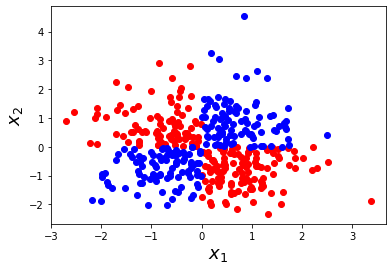

In [3]:
X_train = np.random.randn(400, 2)
y_train = np.logical_xor(X_train[:, 0] > 0, X_train[:, 1] > 0)

blues = y_train == 0
reds = y_train == 1

fig, ax = plt.subplots()
ax.scatter(X_train[reds,0],X_train[reds,1], c='red');
ax.scatter(X_train[blues,0],X_train[blues,1], c='blue');
ax.set_xlabel(r'$x_1$', size=18)
ax.set_ylabel(r'$x_2$', size=18)
plt.show()

We can fit decision trees using the already-familiar sklearn interface ([link to docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).

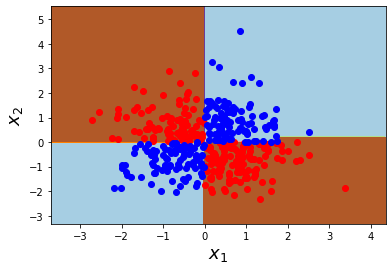

In [4]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, clf)

<div class="alert alert-success">
<b>EXERCISE (warm-up): 
<br>
Think about some other classifiers we have already discussed during this course. How will they square up against the XOR problem? What kind of decision boundary do you expect in the case of e.g. logistic regression? Try plugging some classifiers into the code above and test if the results confirm your intuition.
</b>
</div>

Written answer:

Logistic regression should result in a classifier that randomly draws a single decision line going approximately through the origin. The exact direction and location of that line is random as the linear nature of the classifier will always classify 50% of the samples wrongly, no matter where its location is.

Something extra to think about: what influences the "random" location/direction of the logistic regression decision line? A non-exhaustive list:

- The data itself is randomly generated
- The model weights are randomly initialized
- Your model might use an optimizer that has stochastic elements (the default of logistic regression LFBGS does not), but look up for example stochastic gradient descent.

An example of a previously-seen classifier that will do well on the XOR problem would be, for example, a KNN classifier.

## Pruning decision trees

A naive implementation of a decision tree would grow the number of splits the tree makes until it has correctly predicted all training labels, hence making for a model with high variance (potentially leading to overfitting). Just like other machine learning methods, decision trees can be regularized in various ways (using the [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).

<div class="alert alert-success">
<b>EXERCISE (warm-up): 
<br>
Look into the documentation and identify some hyperparameters that would regularize a decision tree. What would be your preferred way to regularize trees?
</b>
</div>

Written Answer:

A list of the most important ones:

- `max_depth`: decreasing this increases regularization
- `min_samples_split`: increasing this increases regularization
- `min_samples_leaf`: increasing this increases regularization
- `ccp_alpha`: increasing this increases regularization

Preferred way to pick? We don't pick favorites in machine learning, nor do we theoretically reason too much about our datasets (usually). The answer of how to choose will in most cases be provided by simply running a hyperparameter tuning such as grid search and simply seeing what works best (either on a held-out fraction of data or using a cross-validation scheme).

Let's code some stuff on a real dataset. For this we read in the previously-mentioned wisconsin breast cancer dataset:

In [5]:
data = pd.read_csv(
    './wdbc.data',
    index_col=0)
status = data['status']
display(data.head(5))
print('Number of benign cases: ' + str(data[data.loc[:,'status']=='B'].shape[0]))
print('Total number of cases: ' + str(data.shape[0]))

,status,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Number of benign cases: 357
Total number of cases: 569


<div class="alert alert-success">
<b>EXERCISE: 
<br>
Construct a decision tree model that can predict whether a tumor is malign or benign.
Evaluate said model. Optionally, tune your model to make it as good as possible.
</b>
</div>

Some considerations to ponder on:
- Your dataset is quite small, how does this influence your data splitting (e.g. percentages) strategy?
- The labels are unbalanced, how does this influence (1) learning and (2) evaluation? For (2), let's say this data + model pipeline is a first preliminary test as a patient comes in, how could you account for this in your evaluation?

In [6]:
## MOST SIMPLE ANSWER: ##
from sklearn.model_selection import train_test_split

y = (data['status'] == "M").values.astype(int)
X = data.drop('status', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

dt = DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train,y_train)
acc_train = dt.score(X_train,y_train)
acc_test = dt.score(X_test,y_test)

print('Accuracy decision tree on training set: ' + str(acc_train))
print('Accuracy decision tree on test set: ' + str(acc_test))

Accuracy decision tree on training set: 0.9553805774278216
Accuracy decision tree on test set: 0.9202127659574468


In [7]:
## ALTERNATIVE ANSWER USING HYPERPARAMETER TUNING ##
from sklearn.model_selection import train_test_split, GridSearchCV

y = (data['status'] == "M").values.astype(int)
X = data.drop('status', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

dt = DecisionTreeClassifier()

parameter_grid = {
    "max_depth": [2, 3, 4, 5],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"]
    }

clf = GridSearchCV(dt, parameter_grid)
clf.fit(X_train,y_train)
acc_train = clf.score(X_train,y_train)
acc_test = clf.score(X_test,y_test)

print("Best hyperparameters: " + str(clf.best_params_))
print('Accuracy tuned decision tree on training set: ' + str(acc_train))
print('Accuracy tuned decision tree on test set: ' + str(acc_test))

Best hyperparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5}
Accuracy tuned decision tree on training set: 1.0
Accuracy tuned decision tree on test set: 0.9521276595744681


In [8]:
## ALTERNATIVE ANSWER USING HYPERPARAMETER TUNING + EVALUATING MODEL USING RECALL ##
from sklearn.model_selection import train_test_split, GridSearchCV

y = (data['status'] == "M").values.astype(int)
X = data.drop('status', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

dt = DecisionTreeClassifier()

parameter_grid = {
    "max_depth": [2, 3, 4, 5],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"]
    }

clf = GridSearchCV(dt, parameter_grid, scoring = "recall")
clf.fit(X_train,y_train)

# Remember that .score() will use the function provided by the scoring="" argument, so in this case, recall
recall_train = clf.score(X_train,y_train) 
recall_test = clf.score(X_test,y_test)

print("Best hyperparameters: " + str(clf.best_params_))
print('Recall tuned decision tree on training set: ' + str(recall_train))
print('Recall tuned decision tree on test set: ' + str(recall_test))

Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3}
Recall tuned decision tree on training set: 0.9666666666666667
Recall tuned decision tree on test set: 0.9193548387096774


Written note on the answer:

Note that I have supplied 3 separates answers here with increasing complexity. You can run all these three and see what they do. Keep in mind that comparing their scores is in this case here is not correct: we have made three separate splits in each solution. If we wanted to compare scores, we need to do it when using the same evaluation data.

Also, in the last solution, we optimize for recall as this is compliant with the situation sketched above: if we use this pipeline as a preliminary test, we don't care about sending some people to the next round of testing by error, we care more for predicting every positive as positive, which is what recall achieves. [Wikipedia link for a refresher on precision and recall.](https://en.wikipedia.org/wiki/Precision_and_recall)

## Random Forests

Random Forests are a very popular method used in various fields, ranging from bioinformatics to data competitions (have a look at [this introduction](http://onlinelibrary.wiley.com/doi/10.1002/widm.1072/abstract)  for computational biologists and bioinformaticians). This is because they are known for their high performance, yet they are easy to implement. Random Forests make use of two kinds of randomization: 
- The method aggregates the result of individual unpruned trees, grown on bootstrap (sub)samples of the dataset; this is called _bagging_ (**b**ootstrap **agg**regat**ing**). 
- Whenever a decision tree makes a split, only a random subset of the present features are offered to the decision tree. 

Random Forests are part of a larger class of models which are called _ensemble models_. The power of ensemble methods can be attributed to some kind of ["wisdom of the crowd"](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd) phenomenon: averaging the results of many "simple" models is often better than relying on one "advanced" model, just as the collective judgement of a large group of "average" persons may be more reliable than that from one "expert". For random forests, the two kinds of randomization (+ optionally other kinds of regularization) aid in making the individual trees "simple".



After model fitting, for classification, a majority vote for all trees $T_m$ is taken to make a prediction for a new element $x_{new}$: 
\begin{equation}
\hat{y}_{new} = 0 \quad \text{if} \quad  \sum_{m=1}^M T_m(x_{new}) / M < 0.5, \\
\hat{y}_{new} = 1 \quad \text{if} \quad  \sum_{m=1}^M T_m(x_{new}) / M > 0.5.   
\end{equation}

For regression problems, the average across trees is simply taken.


The [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) of random forests works similarly to that of decision trees, with some different parameters. The two most important hyperparameters are the number of trees that is grown and the number of subsetted features that is offered when making a split. The default values of these parameters usually lead to a good performance, although it is of course recommended to do some model selection.

<div class="alert alert-success">

<b>EXERCISE: 
<br>
Repeat the previous model analysis. Use the same data split you made earlier. Investigate what features are important for prediction according to the model.
</b>
</div>

At the end of this exercise, you will (normally) have one final score for your decision tree model and one for your random forest model, allowing comparison between the two.

Let's say you worked for a hospital, and you wanted to report your results to the hospital department that would use your model and for instance say "I have a model that is x% accurate", would you use the scores obtained in this analysis?

Additionally, how would you explain the feature importances to a biologist looking at your results? How do you think the feature importances are influenced by the feature resampling hyperparameter in the model?

Note: If you implement tuning here, take note that for every model hyperparameter setup you are evaluating, you are in fact evaluating an ensemble of smaller models. I.e. Random forests are inherently more computationally demanding than single trees. What kind of effect does this has on your hyperparameter tuning, what can you do?

In [9]:
## ALTERNATIVE ANSWER USING HYPERPARAMETER TUNING + EVALUATING MODEL USING RECALL ##
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

y = (data['status'] == "M").values.astype(int)
X = data.drop('status', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf = RandomForestClassifier()

parameter_grid = {
    "max_depth": [2, 3],
    "n_estimators": [10, 50, 100],
    "max_features": [0.5, 0.75],
    "max_samples": [0.5, 0.75]
    }

clf = GridSearchCV(rf, parameter_grid, scoring = "recall")
clf.fit(X_train,y_train)

# Remember that .score() will use the function provided by the scoring="" argument, so in this case, recall
recall_train = clf.score(X_train,y_train) 
recall_test = clf.score(X_test,y_test)

print("Best hyperparameters: " + str(clf.best_params_))
print('Recall tuned random forest on training set: ' + str(recall_train))
print('Recall tuned random forest on test set: ' + str(recall_test))

Best hyperparameters: {'max_depth': 2, 'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 100}
Recall tuned random forest on training set: 0.9166666666666666
Recall tuned random forest on test set: 0.9705882352941176


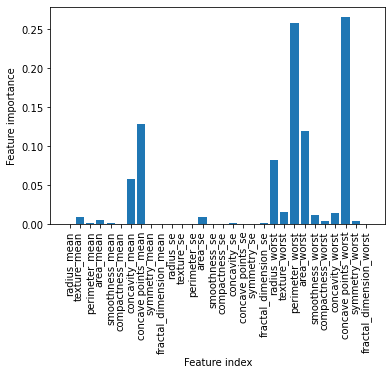

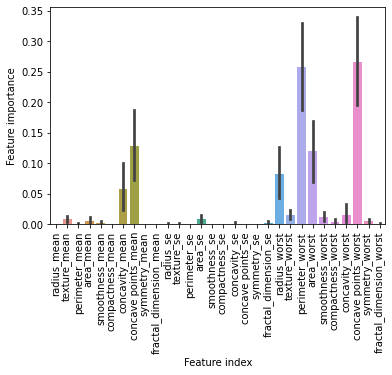

In [10]:
# simple plot using the feature importance attribute in the RF object:
plt.figure()
plt.bar(
    x = np.arange(X.shape[1]),
    height = clf.best_estimator_.feature_importances_
    )
plt.ylabel('Feature importance')
plt.xlabel('Feature index')
plt.xticks(ticks = np.arange(X.shape[1]), labels = data.columns[1:], rotation = 90)

# More elaborate using the features importances of all the trees in the RF object to get error bars:
import seaborn as sns

importances = np.array([tree.feature_importances_ for tree in clf.best_estimator_.estimators_])
indices = np.array([np.arange(importances.shape[1]) for _ in range(importances.shape[0])])
data_to_plot = pd.DataFrame([indices.reshape(-1), importances.reshape(-1)]).T
data_to_plot[0] = data_to_plot[0].astype(int)
plt.figure()
sns.barplot(data = data_to_plot, x=0, y=1)
plt.ylabel('Feature importance')
plt.xlabel('Feature index')
plt.xticks(ticks = np.arange(X.shape[1]), labels = data.columns[1:], rotation = 90)
plt.show()

## Extra: XGBoost

Boosting is a subclass of ensembling in which (similarly) many simpler models team up to create a performant model. The difference is that in boosting, subsequent trees try to correct the mistakes of the previous one(s). The most famous example, XGBoost or eXtreme Gradient Boosting is a decision-tree-based algorithm that uses a gradient boosting framework. The algorithm was developed by Tianqi Chen and Carlos Guestrin and more details can be found [here](https://arxiv.org/pdf/1603.02754.pdf). The technique has managed to win numerous kaggle competitions and is currently tied to an active open source [project](https://github.com/dmlc/xgboost/). 

**Informally, performant boosting implementations such as XGBoost, [CatBoost](https://catboost.ai/) and [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/), have been crowned as kings of machine learning on tabular, structured datasets. (As opposed to various deep learning architectures which have been informally crowned as kings of "perceptual", unstructured data such as, language, vision, audio, ...)**



Some of the main characteristics that make XGboost an appealing choice include:
- Can be used to solve different type of prediction problems (regression, classification, ranking)
- Runs on every popular OS (Windows, Linux, and OS X)
- Supports all major programming languages (C++, Python, R, Java, Scala, and Julia)


The library we are going to use is quite flexible as it supports the following cases:

- Trees are constructed in parallel using all of available CPU cores during training.
- Very large models can use a cluster of machines in a distributed fashion.
- Very large datasets that don’t fit into memory are handled with out-of-Core Computing.

There is no additional exercise linked to XGBoost. It suffices to say that the XGBoost python package can be installed with the cell below and that the package uses a similar API as in scikit learn: `.fit()`, `.predict()`, ... More information on input arguments here: [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) and [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier). We invite you to play around with the model by plugging XGBoost in the above exercise.

In [11]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Extra: Feature importance, correlation and causality

Consider the three following causal graphs:

<img src="https://raw.githubusercontent.com/gdewael/teaching/main/predmod/RF/RF.png" width = 800>

In scenario 1, we have two features that are (additively) influencing a prediction target `Y`, the second feature more noisily influencing the target than the first. There is also a feature that is unconnected to both other features and target.

In scenario 2, the only feature causally influencing the target is the first, which also influences the second feature.

In scenario 3, X1 still influences X2, which in turn influences the target.

We can simulate these scenarios with some random variables:

In [12]:
# Scenario 1:

X1 = np.random.randn(100)

X2 = np.random.randn(100)

Y = X1 + X2 * (np.random.randn(100) + 1) 

X3 = np.random.randn(100)

X = np.stack([X1, X2, X3]).T

In [13]:
# Scenario 2
X1 = np.random.randn(100)

X2 = X1 + np.random.randn(100) / 5

Y = X1 + np.random.randn(100) / 5

X3 = np.random.randn(100)

X = np.stack([X1, X2, X3]).T

In [14]:
# Scenario 3

X1 = np.random.randn(100)

X2 = X1 + np.random.randn(100) / 5

Y = X2 + np.random.randn(100) / 5

X3 = np.random.randn(100)

X = np.stack([X1, X2, X3]).T

<div class="alert alert-success">

<b>THOUGHT EXERCISE: 
<br>
Run a cell corresponding to a scenario to get a simulated dataset, then run the cell below to get random forest feature importances. Do they confirm to what you want out of a model? What happens if you change the `max_features` argument to a value below 1?
</b>
</div>

A similar analysis can be run using linear regression (L2 / ridge regularized) instead of random forests (max_features regularized). 

Ponder over these questions:
- If our feature importances from ML are still correlative, and not causal, why are we doing ML at all? (As opposed to just computing statistical correlations between target and features)
- If feature importances can be so easily tweaked with the arbitrary change of some hyperparameter, should we trust them?

Causality in ML is out-of-scope for this course. For those interested, [this](https://towardsdatascience.com/be-careful-when-interpreting-predictive-models-in-search-of-causal-insights-e68626e664b6) is an excellent primer article introducing some key concepts of causal inference.

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=1.).fit(X, Y)
rf.feature_importances_

array([0.34294407, 0.6441575 , 0.01289843])

Written answer:

`max_features` has a regularizing effect similar to ridge regression, it forces the model to consider a potential correlation in each feature.